In [1]:
# base
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Загрузка данных (colab)

In [2]:
import gdown

url = "https://drive.google.com/file/d/1a9eo-9XzqZ1XFBaqfJHdecoB-oG-ch5B/view?usp=sharing"
output = "data.zip"
gdown.download(url=url, output=output, quiet=False, fuzzy=True)

Downloading...
From (original): https://drive.google.com/uc?id=1a9eo-9XzqZ1XFBaqfJHdecoB-oG-ch5B
From (redirected): https://drive.google.com/uc?id=1a9eo-9XzqZ1XFBaqfJHdecoB-oG-ch5B&confirm=t&uuid=f1b02cb7-20be-4559-94fa-70954dc5de94
To: /content/data.zip
100%|██████████| 26.6M/26.6M [00:01<00:00, 24.0MB/s]


'data.zip'

In [3]:
!mkdir data
!mkdir data/raw

In [4]:
!unzip data.zip -d data/raw

Archive:  data.zip
  inflating: data/raw/data_final_for_dls_new.jsonl  
  inflating: data/raw/data_final_for_dls_eval_new.jsonl  


In [5]:
!rm data.zip

In [6]:
data_eval = pd.read_json("data/raw/data_final_for_dls_eval_new.jsonl", lines=True)
data = pd.read_json("data/raw/data_final_for_dls_new.jsonl", lines=True)

data.drop(columns='relevance', inplace=True)
data_eval.drop(columns='relevance', inplace=True)

data.rename(columns={'relevance_new': 'relevance'}, inplace=True)
data_eval.rename(columns={'relevance_new': 'relevance'}, inplace=True)

# 0. Проведем небольшой EDA


In [7]:
data.sample(5)

,Text,address,name,normalized_main_rubric_name_ru,permalink,prices_summarized,reviews_summarized,relevance
24613,гаи бедного,"Липецк, улица М.И. Неделина, 2",Специализированный взвод ДПС ГИБДД оперативног...,Госавтоинспекция,1326199252,None,Организация занимается регулированием дорожног...,0.1
22482,Ателье по пошиву и ремонту одежды,"Санкт-Петербург, проспект Энгельса, 133к1В",Пуговка; Atelye Pugovka,Ателье по пошиву одежды,1308668077,None,None,1.0
9754,Грузовая компания,"Новосибирск, Толмачёвская улица, 1","Клещиха, грузовой терминал РЖД; Cargo Terminal...",Складские услуги,63057905251,None,Организация занимается складскими услугами и л...,1.0
1316,стерилизация кошек в тольятти цены,"Самарская область, Тольятти, проезд Пожарского...",Надежда; Nadezhda,Ветеринарная клиника,1234896080,None,Организация занимается ветеринарными услугами ...,0.0
7452,где поесть ночью в спб,"Санкт-Петербург, Петергоф, Спортивная улица, 1",Night,Кафе,168322196230,None,Организация занимается предоставлением услуг к...,0.1


In [8]:
data_eval.sample(5)

,Text,address,name,normalized_main_rubric_name_ru,permalink,prices_summarized,reviews_summarized,relevance
128,психиатрическая больница,"Санкт-Петербург, Канонерская улица, 12",Санкт-Петербургская городская психиатрическая ...,Инфраструктура образования,178726643182,None,Организация занимается оказанием психиатрическ...,0.1
394,музей секса,"Свердловская область, Екатеринбург, улица Луна...",Музей Об Этом; Ob Etom; Об Этом; Музей об этом...,Музей,211016878377,None,Организация «Музей Об Этом» сочетает функции м...,1.0
198,общежитие для ординаторов москва,"Москва, улица Адмирала Макарова, 23, корп. 2",Добрый Дом; Dobry Dom; Dobry Dom Hostel,Хостел,91002332562,Хостел «Добрый Дом» предоставляет проживание в...,Хостел «Добрый Дом» предоставляет проживание в...,0.0
418,салат лиза,"Омск, улица Ленина, 14",Японский домик; Yapdomik,Суши-бар,55275738535,"Японский домик — суши-бар и кафе, предлагающее...",Организация «Японский домик» занимается пригот...,0.0
11,белорусские кухни зов в москве официальный сай...,"Москва, Волгоградский проспект, 132",Кухни Зов; Zov; Зов; Зов Кухни; Kuhni-zov,Мебель для кухни,127861447693,Компания «Кухни Зов» предлагает разнообразные ...,Организация занимается изготовлением кухонь и ...,1.0


#### Что означают колонки:

In [9]:
data.sample(1).T.to_dict()

{33149: {'Text': 'аренда квартир анапа авито длительный срок',
  'address': 'Краснодарский край, Анапа, улица Ленина, 26',
  'name': 'Ваш город; Vash gorod',
  'normalized_main_rubric_name_ru': 'Агентство недвижимости',
  'permalink': 214405356737,
  'prices_summarized': 'Агентство недвижимости «Ваш город» предлагает квартиры в новостройках и земельные участки. | квартиры в новостройках | земельные участки',
  'reviews_summarized': 'Организация занимается продажей квартир в новостройках и земельных участков. Отзывы смешанные: 1 положительный, 1 нейтральный с критикой, 1 отрицательный. Хвалят персонал и профессионализм сотрудников. Критикуют уровень подготовки агентов и высокие цены. | 1. Критикует низкий уровень подготовки агента Ирины и грамотность речи | 2. Считает место неплохим, но отмечает высокие цены | 3. Хвалят персонал и профессионализм, хороший офис',
  'relevance': 1.0}}

In [10]:
print(f"Всего уникальных запросов в данных: {data['Text'].nunique()} из {len(data)}")

Всего уникальных запросов в данных: 9332 из 35094


In [11]:
data.sample(5)['Text'].to_list()

['кондитерская семечка Краснодар',
 'для трудоустройства на работу пройти психа и нарколога прописка в кадуе',
 'парикмахерская мужская',
 'упаковка из фанеры осб москва',
 'продуктовые оптовые базы']

In [12]:
data[data['Text'] == data.sample(1)['Text'].to_list()[0]]

,Text,address,name,normalized_main_rubric_name_ru,permalink,prices_summarized,reviews_summarized,relevance
1,кальянная спб мероприятия,"Санкт-Петербург, Большой проспект Петроградско...",PioNero; Pionero; Пицца Паста бар; Pio Nero; P...,Кафе,228111266197,PioNero предлагает разнообразные блюда итальян...,"Организация PioNero — это кафе, бар и ресторан...",0.0
2927,кальянная спб мероприятия,"Санкт-Петербург, Мучной переулок, 1/38",Дымный БРО; DymnyiBro; ДымныйБро; Taboo HookaH...,Кальян-бар,191447853206,Дымный БРО предлагает кальяны и создаёт атмосф...,Организация «Дымный БРО» предлагает услуги кал...,0.0
18179,кальянная спб мероприятия,"Санкт-Петербург, улица Рубинштейна, 27",1/2 Of You; Hookah bar 1/2 Of You; 1/2 of you;...,Кальян-бар,1749660537,"Ресторан предлагает разнообразные блюда, включ...",Организация занимается предоставлением услуг к...,0.0


Оценки
* 1.0 => "RELEVANT_PLUS" - релевантное заведение. Занчение 1.0
* 0.1 => "RELEVANT_MINUS" — в целом может быть релевантна, если нет других вариантов получше. Например, по запросу "Кофе" показать не кофейню, а условный вкусвилл с кафе
* 0.0 => "IRRELEVANT" - не подходит под запрос

Nan'ы

In [13]:
data.isna().sum()

,0
Text,0
address,0
name,0
normalized_main_rubric_name_ru,0
permalink,0
prices_summarized,14465
reviews_summarized,1539
relevance,0


### Посмотрим на распределения классов.

In [14]:
print(f"Всего уникальных запросов в данных: {data['Text'].nunique()} из {len(data)}")

Всего уникальных запросов в данных: 9332 из 35094


#### 1. Полное распределение классов.

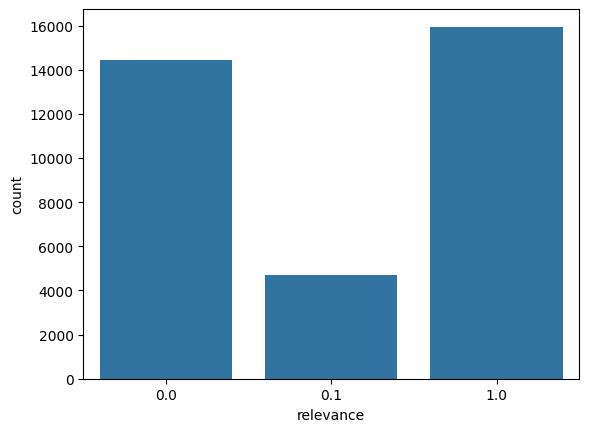

1.0 :15950 (45.45%)
0.1 :4703 (13.40%)
0.0 :14441 (41.15%)


In [15]:
sns.countplot(data=data, x='relevance', )
plt.show()
n = len(data)
minus = len(data[data['relevance'] == 0.1])
plus = len(data[data['relevance'] == 1.0])
irr = len(data[data['relevance'] == 0.0])
print(f"1.0 :{plus} ({plus/n * 100:.2f}%)")
print(f"0.1 :{minus} ({minus/n * 100:.2f}%)")
print(f"0.0 :{irr} ({irr/n * 100:.2f}%)")

#### 2. Распределение классов для каждого заведения

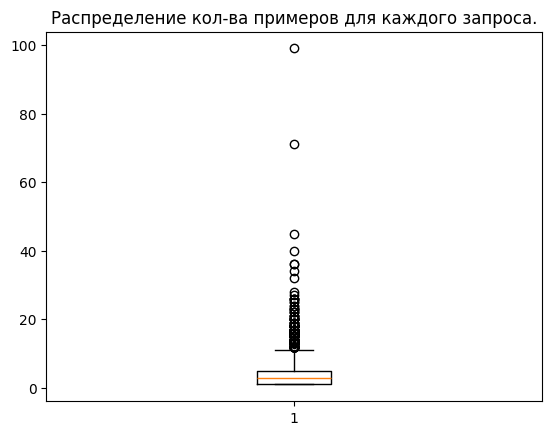

In [16]:
counts = data.groupby('Text').size().reset_index(name='count')
plt.boxplot(counts['count'])
plt.title("Распределение кол-ва примеров для каждого запроса.")
plt.show()

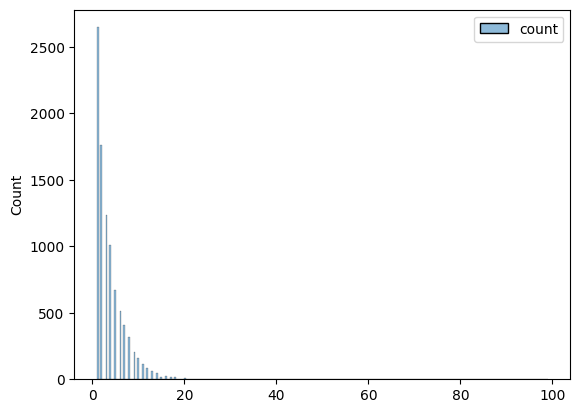

In [17]:
sns.histplot(data=counts)
plt.show()

# Написание бейзлайна (2 балла)

Что вообще должен из себя представлять бейзлайн?

1) Дообучить Классификатор на трансформере.
2) Тупо запрос в LLM
Реализуем обе этих тактики, посмотрим на результат.


## 1. Дообучение классификатора на трансформере.

In [18]:
import os
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler
from torch.optim.lr_scheduler import ExponentialLR
from torch import Tensor

from tqdm import tqdm
from omegaconf import DictConfig
from sklearn.metrics import f1_score

from transformers import AutoTokenizer, AutoModel

In [19]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

### 1.1 Подготовка данных.

Методы для обработки данных (можно потом перенести в датасет):

In [20]:
def make_object_text(row):
    return (
        f"Запрос: {row['Text']}. "
        f"Результат: "
        f"Название: {row['name']}\n"
        f"Рубрика: {row['normalized_main_rubric_name_ru']}\n"
        f"Адрес: {row['address']}\n"
        f"Цены: {row['prices_summarized']}\n"
        f"Отзывы: {row['reviews_summarized']}"
    )

document = data.apply(make_object_text, axis=1)
document_val = data_eval.apply(make_object_text, axis=1)

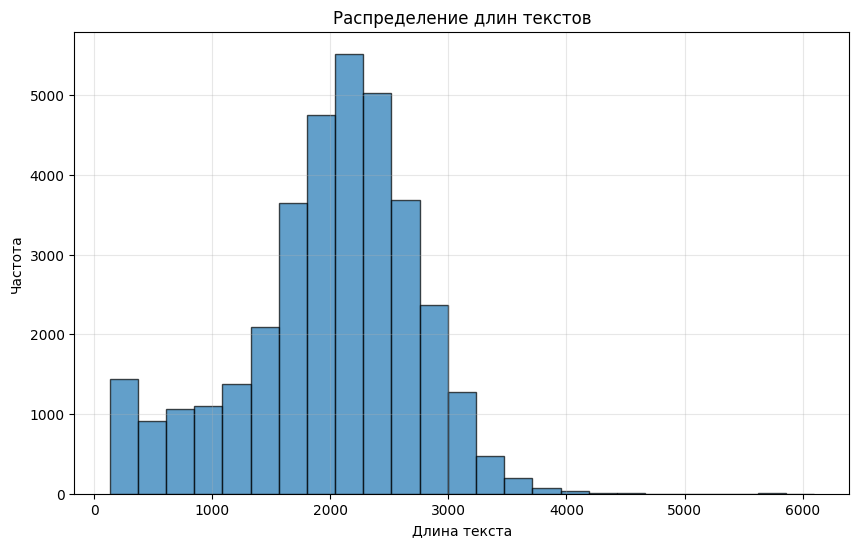

In [21]:
plt.figure(figsize=(10, 6))
plt.hist(document.apply(len), bins=25, edgecolor='black', alpha=0.7)
plt.title('Распределение длин текстов')
plt.xlabel('Длина текста')
plt.ylabel('Частота')
plt.grid(alpha=0.3)
plt.show()

In [22]:
ind2label = {0:0.0, 1:1.0, 2:0.1}
label2ind = {0.0:0, 1.0:1, 0.1:2}

relevances = data['relevance'].map(label2ind)
relevances_val = data_eval['relevance'].map(label2ind)

Датасет

In [23]:
class OrgDataset(Dataset):
    def __init__(self, df, relevances):
        # data
        self.data = df.to_list()
        self.targets = relevances.to_list()


    def __getitem__(self, idx):
        # Get text and label for this text
        text = self.data[idx]

        target = self.targets[idx]

        return text, target

    def __len__(self):
        return len(self.data)


class CollateCall:
    def __init__(self, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __call__(self, batch):
        texts, targets = zip(*batch)

        batch_dict = tokenizer(
            texts,
            padding=True,
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt",
        )

        targets = torch.tensor(targets, dtype=torch.long)


        return batch_dict, targets

Создание датасетов и загрузка модели

### Model Class

In [24]:
class TransformerModel(nn.Module):
    def __init__(self, base_model: str, n_classes):
        super().__init__()
        # 1) BackBone
        self.backbone = AutoModel.from_pretrained(base_model)

        # 2) Cls Head
        hidden_size = self.backbone.config.hidden_size

        self.head = nn.Sequential(
             nn.Linear(hidden_size, hidden_size),
             nn.ReLU(),
             nn.Dropout(0.2),
             nn.LayerNorm(hidden_size),
             nn.Linear(hidden_size, n_classes)
        )

    @staticmethod
    def last_token_pool(last_hidden_states: Tensor,attention_mask: Tensor) -> Tensor:
        left_padding = (attention_mask[:, -1].sum() == attention_mask.shape[0])
        if left_padding:
            return last_hidden_states[:, -1]
        else:
            sequence_lengths = attention_mask.sum(dim=1) - 1
            batch_size = last_hidden_states.shape[0]
            return last_hidden_states[torch.arange(batch_size, device=last_hidden_states.device), sequence_lengths]

    def forward(self, **input_batch):
        # get model outputs
        model_outputs = self.backbone(**input_batch)
        # get [CLS] embeddings
        cls_embeddings = self.last_token_pool(model_outputs.last_hidden_state, input_batch['attention_mask'])

        head_outputs = self.head(cls_embeddings)

        return head_outputs

In [25]:
def freeze_backbone_function(model: TransformerModel):
    # разморозим всё
    for p in model.parameters():
        p.requires_grad = True

    # заморозим только backbone
    for p in model.backbone.parameters():
        p.requires_grad = False

    return model

### Metrics methods

В работе будем использовать accuracy, f1

### Train Methods


In [26]:
basic_config = {
    "LR": 3e-4,
    "DECAY": 1e-6,
    "NAME": "baseline_classifier",
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "SCHED_GAMMA": 0.97,
    "SAVE_DIR": "models",
    "SAVE_BEST": True,
}


def calculate_accuracy(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """
    Calculate accuracy using basic formula
    """
    if len(y_true) == 0:
        return 0.0
    return float((y_true == y_pred).mean())


class CustomTrainer:
    def __init__(self, config: DictConfig | dict | None = None, freeze_backbone_fn=None,
                 save_dir: str = None,
                 save_best: bool = None,
    ):
        if config is None:
            config = basic_config

        if isinstance(config, DictConfig):
            self.cfg = config
        else:
            self.cfg = DictConfig(config)

        # overrides if passed
        if save_dir is not None:
            self.cfg.SAVE_DIR = save_dir
        if save_best is not None:
            self.cfg.SAVE_BEST = save_best

        self.device = self.cfg.device
        self.freeze_backbone_fn = freeze_backbone_fn

        # will be created in train()
        self.criterion = None
        self.optimizer = None
        self.scheduler = None
        self.scaler = None

        # learning history
        self.history = {
            "train_loss": [],
            "train_f1": [],
            "train_acc": [],
            "val_f1": [],
            "val_acc": [],
        }

    def _prepare_batch(self, batch):
        """
        Метод для переноса батча на устройство.
        """

        if isinstance(batch, (list, tuple)) and len(batch) == 2:
            x, y = batch
            if isinstance(x, dict):
                x = {k: v.to(self.device) for k, v in x.items()}
            else:
                x = x.to(self.device)
            y = y.to(self.device)
            return x, y

        raise TypeError(f"Unsupported batch format: {type(batch)}")

    def train(self, model, trainloader, valloader=None, num_epochs=10, freeze_backbone: bool = True):
        # 1. freeze backbone if needed
        if freeze_backbone:
            model = self.freeze_backbone_fn(model)

        # 2. device
        model = model.to(self.device)

        self.cfg.EPOCHS = num_epochs

        # 3. loss / optimizer
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(model.parameters(), lr=self.cfg.LR)

        # 4. scheduler / scaler
        self.scheduler = ExponentialLR(self.optimizer, gamma=float(self.cfg.SCHED_GAMMA))
        self.scaler = GradScaler()

        # 5. saving setup
        os.makedirs(self.cfg.SAVE_DIR, exist_ok=True)
        es_best_metrics = -1.0 # best metrics for early stopping

        epoch_bar = tqdm(range(self.cfg.EPOCHS), desc="Epochs", position=0, leave=True)
        for epoch in epoch_bar:
            train_loss, train_f1, train_acc = self.train_one_epoch(
                model=model,
                trainloader=trainloader,
                epoch=epoch,
                epochs=self.cfg.EPOCHS,
            )


            self.history["train_loss"].append(train_loss)
            self.history["train_f1"].append(train_f1)
            self.history["train_acc"].append(train_acc)

            if valloader is not None:
                self.history["val_f1"].append(val_f1)
                self.history["val_acc"].append(val_acc)
            else:
                val_f1, val_acc = None, None

            # log
            if val_f1 is not None:
                tqdm.write(
                    f"Epoch {epoch+1}/{self.cfg.EPOCHS} "
                    f"| Train loss {train_loss:.4f} | f1 {train_f1:.4f} | acc {train_acc:.4f} "
                    f"| Val f1 {val_f1:.4f} | Val acc {val_acc:.4f}"
                )
            else:
                tqdm.write(
                    f"Epoch {epoch+1}/{self.cfg.EPOCHS} "
                    f"| Train loss {train_loss:.4f} | f1 {train_f1:.4f} | acc {train_acc:.4f}"
                )

            # scheduler step
            self.scheduler.step()

            # save best
            if self.cfg.SAVE_BEST and (val_f1 is not None) and (val_f1 >= es_best_metrics):
                es_best_metrics = val_f1
                best_state = {
                    "epoch": epoch,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": self.optimizer.state_dict(),
                    "val_f1": es_best_metrics,
                    "config": dict(self.cfg),
                }
                torch.save(
                    best_state,
                    os.path.join(self.cfg.SAVE_DIR, f"best_model_{self.cfg.NAME}_{epoch}.pt"),
                )

        torch.cuda.empty_cache()
        return model, self.history

    def train_one_epoch(self, model, trainloader, epoch: int, epochs: int):
        model.train()

        epoch_loss = 0.0
        all_trues = []
        all_preds = []
        all_examples = 0

        pbar = tqdm(trainloader, desc=f"Train {epoch+1}/{epochs}", position=1, leave=False)

        for batch in pbar:
            self.optimizer.zero_grad(set_to_none=True)

            inputs, labels = self._prepare_batch(batch)

            with torch.amp.autocast(device_type=self.device, dtype=torch.bfloat16):
                logits = model(**inputs)

                loss = self.criterion(logits, labels)

            self.scaler.scale(loss).backward()
            self.scaler.step(self.optimizer)
            self.scaler.update()

            bs = labels.size(0)
            epoch_loss += loss.item() * bs
            all_examples += bs

            preds = torch.argmax(logits, dim=-1)
            all_preds.extend(preds.detach().cpu().numpy())
            all_trues.extend(labels.detach().cpu().numpy())

            pbar.set_postfix(loss=epoch_loss / max(all_examples, 1))

        all_trues = np.array(all_trues)
        all_preds = np.array(all_preds)

        result_loss = epoch_loss / max(all_examples, 1)
        f1_train = f1_score(all_trues, all_preds, average="macro")
        accuracy = calculate_accuracy(all_trues, all_preds)

        return result_loss, f1_train, accuracy

    def eval(self, model, valloader):
        model.eval()
        progress_bar = tqdm(total=len(valloader), unit="step", desc="Val", position=1, leave=False)

        all_trues = []
        all_preds = []
        all_examples = 0

        with torch.no_grad():
            for batch in valloader:
                inputs, labels = self._prepare_batch(batch)

                logits = model(**inputs)

                preds = torch.argmax(logits, dim=-1)

                all_examples += labels.size(0)
                all_preds.extend(preds.detach().cpu().numpy())
                all_trues.extend(labels.detach().cpu().numpy())

                progress_bar.update(1)

        all_trues = np.array(all_trues)
        all_preds = np.array(all_preds)

        f1_val = f1_score(all_trues, all_preds, average="macro")
        accuracy = calculate_accuracy(all_trues, all_preds)

        return float(f1_val), float(accuracy)

    def plot_training_history(self, print_results=True):
        """
        Строит графики обучения из history


            self.history (dict): словарь с историей обучения, содержащий:
                - train_loss: список лоссов на тренировке
                - train_f1: список F1-score на тренировке
                - train_acc: список accuracy на тренировке
                - val_f1: список F1-score на валидации
                - val_acc: список accuracy на валидации
        """
        if len(self.history) == 0:
            raise ValueError("History is empty")

        epochs = range(1, len(self.history['train_loss']) + 1)

        # Создаем фигуру с 3 subplots
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))

        # 1. График лосса
        axes[0].plot(epochs, self.history['train_loss'], 'b-', label='Train Loss', linewidth=2)
        axes[0].set_title('Training Loss')
        axes[0].set_xlabel('Epochs')
        axes[0].set_ylabel('Loss')
        axes[0].grid(True, alpha=0.3)
        axes[0].legend()

        # 2. График accuracy (train и val)
        axes[1].plot(epochs, self.history['train_acc'], 'g-', label='Train Accuracy', linewidth=2)
        axes[1].plot(epochs, self.history['val_acc'], 'r-', label='Val Accuracy', linewidth=2)
        axes[1].set_title('Training and Validation Accuracy')
        axes[1].set_xlabel('Epochs')
        axes[1].set_ylabel('Accuracy')
        axes[1].grid(True, alpha=0.3)
        axes[1].legend()

        # 3. График F1-score (train и val)
        axes[2].plot(epochs, self.history['train_f1'], 'g-', label='Train F1', linewidth=2)
        axes[2].plot(epochs, self.history['val_f1'], 'r-', label='Val F1', linewidth=2)
        axes[2].set_title('Training and Validation F1-Score')
        axes[2].set_xlabel('Epochs')
        axes[2].set_ylabel('F1-Score')
        axes[2].grid(True, alpha=0.3)
        axes[2].legend()

        plt.tight_layout()
        plt.show()

        if print_results:
            self.print_final_results()

    # Функция для красивого вывода финальных результатов
    def print_final_results(self):
        """
        Выводит финальные результаты обучения
        """
        print("=" * 60)
        print("FINAL TRAINING RESULTS")
        print("=" * 60)

        final_epoch = len(self.history['train_loss'])

        print(f"Final Train Loss: {self.history['train_loss'][-1]:.4f}")
        print(f"Final Train Accuracy: {self.history['train_acc'][-1]:.4f}")
        print(f"Final Train F1: {self.history['train_f1'][-1]:.4f}")
        print(f"Final Val Accuracy: {self.history['val_acc'][-1]:.4f}")
        print(f"Final Val F1: {self.history['val_f1'][-1]:.4f}")

        # Находим лучшие результаты на валидации
        best_val_acc_epoch = np.argmax(self.history['val_acc']) + 1
        best_val_f1_epoch = np.argmax(self.history['val_f1']) + 1

        print(f"Best Val Accuracy: {np.max(self.history['val_acc']):.4f} (epoch {best_val_acc_epoch})")
        print(f"Best Val F1: {np.max(self.istory['val_f1']):.4f} (epoch {best_val_f1_epoch})")
        print("=" * 60)

### For Inference

In [27]:
class InferenceHelper:
    def __init__(self, model, dataloader):
        self.model = model
        self.dataloader = dataloader

### Training a model

In [28]:
MODEL_NAME = 'Qwen/Qwen3-Embedding-0.6B'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, padding_side='left')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

In [29]:
model_baseline = TransformerModel(MODEL_NAME, 3)

config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.19G [00:00<?, ?B/s]

In [30]:
train_dataset = OrgDataset(document, relevances)
val_dataset = OrgDataset(document_val, relevances_val)

collate_function = CollateCall(tokenizer, 2048)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=10, collate_fn=collate_function, num_workers=2)
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=10, collate_fn=collate_function)

In [31]:
config = {
    "LR": 3e-4,
    "NAME": "baseline_classifier",
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "SCHED_GAMMA": 0.97,
    "SAVE_DIR": "models",
    "SAVE_BEST": True,
}

Trainer = CustomTrainer(config, freeze_backbone_function)

In [32]:
try:
    Trainer.train(model_baseline, train_dataloader, val_dataloader, num_epochs=10, freeze_backbone=True)
except Exception as e:
    print(f"Error: {e}")
    torch.cuda.empty_cache()

# self, model, trainloader, valloader=None, freeze_backbone: bool = True

/tmp/ipython-input-2935009429.py:90: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = GradScaler()
Epochs:   0%|          | 0/10 [09:51<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
print(torch.cuda.memory_summary())

In [ ]:
torch.cuda.empty_cache()

#